## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


In [2]:
# set random seed
seed(10)
set_random_seed(10)

# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

10분간 데이터를 수집해 하나의 포인트로 설정

10분 데이터는 20480개의 데이터가 수집되고 이를 평균내서 사용

In [19]:
# 10분간 데이터를 수집하고 하나의 포인트로 설정 
### 
# data_dir = 'data'
# lst = os.listdir(data_dir)
# lst.sort()

# dataset = pd.read_csv(os.path.join(data_dir, '2004.02.16.16.22.39'), sep='\t')
# print('dataset : ', dataset.shape)
# dataset.describe()
# dataset_mean_abs = np.array(dataset.abs().mean())
# print('dataset_mean_abs : ',dataset_mean_abs.shape)
# dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
# print('dataset_mean_abs_reshape : ',dataset_mean_abs.shape)
# dataset_mean_abs.index = ['2004.02.16.16.22.39']
# dataset_mean_abs.describe()


dataset :  (20479, 4)


,-0.049,-0.115,0.020,0.039
count,20479.000000,20479.000000,20479.000000,20479.000000
mean,-0.001822,-0.001350,-0.001751,-0.002670
std,0.094523,0.093683,0.098081,0.056045
min,-0.466000,-0.376000,-0.779000,-0.239000
25%,-0.061000,-0.066000,-0.063000,-0.039000
50%,-0.002000,-0.002000,-0.002000,-0.002000
75%,0.059000,0.061000,0.061000,0.034000
max,0.479000,0.466000,0.647000,0.234000


In [20]:
# load, average and merge sensor samples
data_dir = 'data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [21]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.16.16.22.39,0.073814,0.074713,0.075640,0.044425
2004.02.15.16.42.39,0.059662,0.073159,0.075952,0.042869
2004.02.17.16.52.39,0.092946,0.078138,0.077772,0.050036
2004.02.15.12.22.39,0.060525,0.074383,0.078142,0.044174
2004.02.17.02.42.39,0.078344,0.074184,0.079004,0.046181


In [23]:
# transform data file index to datetime and sort in chronological order
# 시간 양식을 수정
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
# 시간 순으로  sort
merged_data = merged_data.sort_index()
# csv로 저장
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [24]:
# train은 정상 데이터로 구성
## 그런데 왜 나중에 train_X로 테스트 할때 비정상 구간이 나오는 걸까??
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']

test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


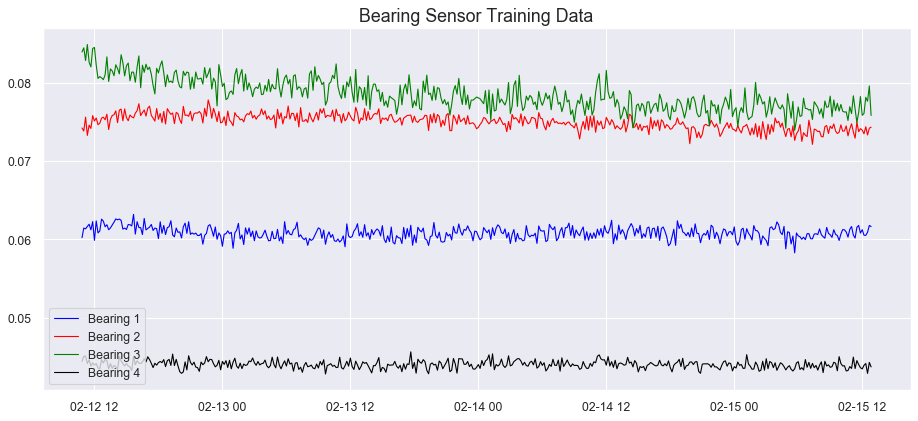

In [7]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [8]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

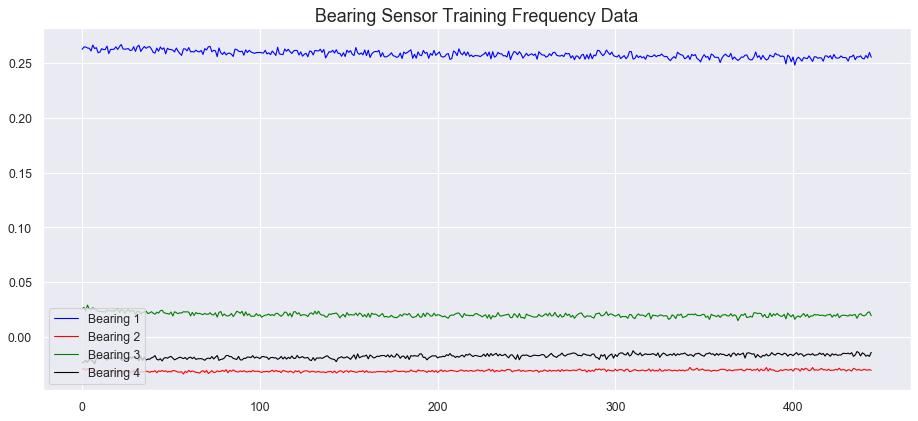

In [9]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

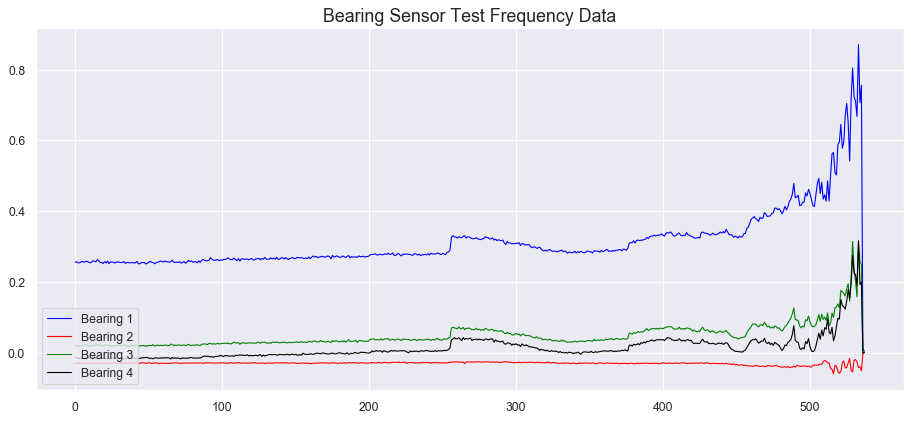

In [10]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [25]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [26]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [27]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [28]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 4)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)              68  

In [29]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 422 samples, validate on 23 samples
Epoch 1/100
422/422 [==============================] - 3s 6ms/step - loss: 0.4472 - val_loss: 0.3244
Epoch 2/100
422/422 [==============================] - 0s 996us/step - loss: 0.3899 - val_loss: 0.2580
Epoch 3/100
422/422 [==============================] - 0s 939us/step - loss: 0.3122 - val_loss: 0.1798
Epoch 4/100
422/422 [==============================] - 0s 1ms/step - loss: 0.2061 - val_loss: 0.1587
Epoch 5/100
422/422 [==============================] - 0s 958us/step - loss: 0.1277 - val_loss: 0.1404
Epoch 6/100
422/422 [==============================] - 0s 940us/step - loss: 0.1085 - val_loss: 0.1227
Epoch 7/100
422/422 [==============================] - 0s 931us/step - loss: 0.1040 - val_loss: 0.1187
Epoch 8/100
422/422 [==============================] - 0s 929us/step - loss: 0.1025 - val_loss: 0.1147
Epoch 9/100
422/422 [==============================] - 0s 870us/step - loss: 0.1020 - val_loss: 0.1142
Epoch 10/100
422/422 [==========

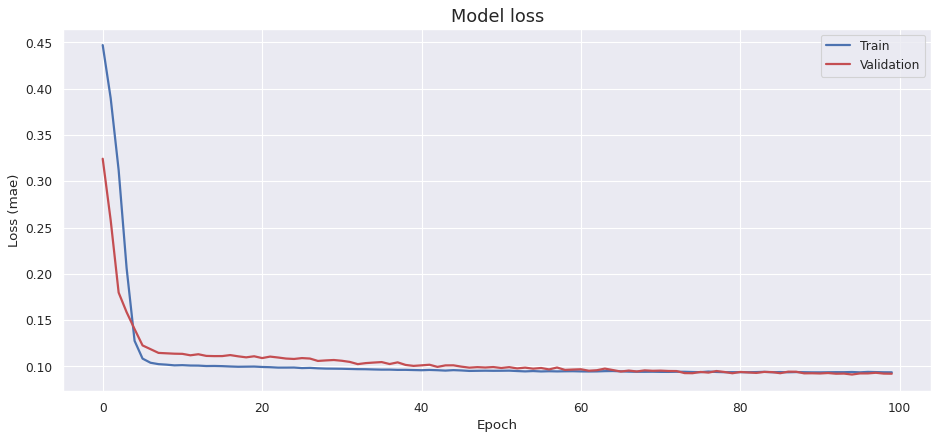

In [30]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

/home/rain/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

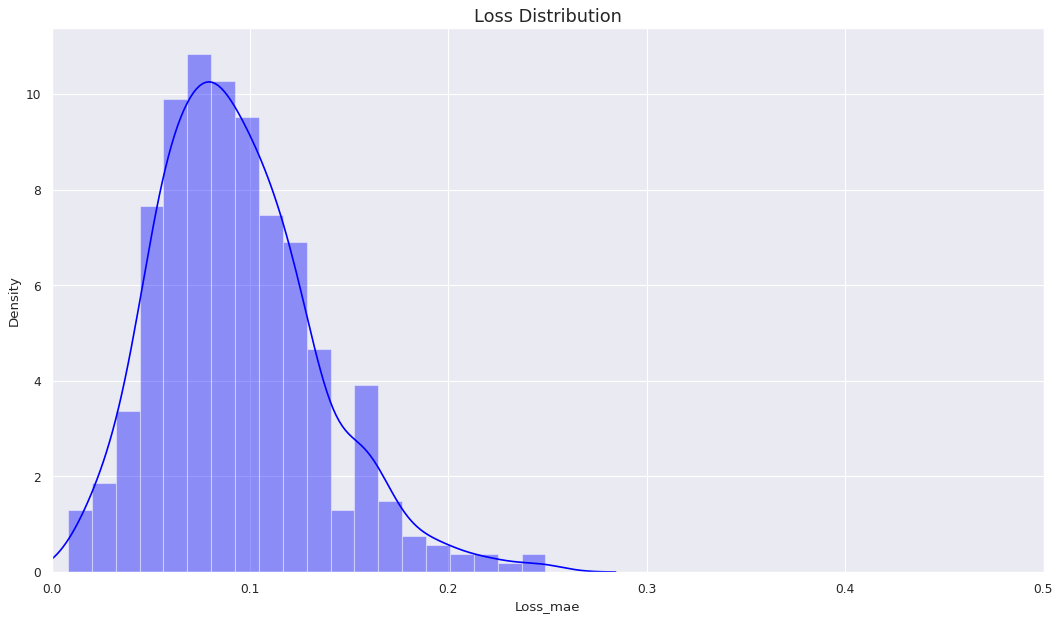

In [32]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue')
plt.xlim([0.0,.5])

In [34]:
scored['Loss_mae'].max()

0.24894171738973458

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [35]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.094382,0.275,False
2004-02-15 13:02:39,0.171183,0.275,False
2004-02-15 13:12:39,0.066514,0.275,False
2004-02-15 13:22:39,0.054245,0.275,False
2004-02-15 13:32:39,0.037089,0.275,False


In [36]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

# train 과 test를 동시에 보기 위해서 합침
scored = pd.concat([scored_train, scored])

In [38]:
scored

,Loss_mae,Threshold,Anomaly
2004-02-12 10:52:39,0.216385,0.275,False
2004-02-12 11:02:39,0.242811,0.275,False
2004-02-12 11:12:39,0.116898,0.275,False
2004-02-12 11:22:39,0.248942,0.275,False
2004-02-12 11:32:39,0.167464,0.275,False
2004-02-12 11:42:39,0.158816,0.275,False
2004-02-12 11:52:39,0.117086,0.275,False
2004-02-12 12:02:39,0.225745,0.275,False
2004-02-12 12:12:39,0.117162,0.275,False
2004-02-12 12:22:39,0.115686,0.275,False


Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:>

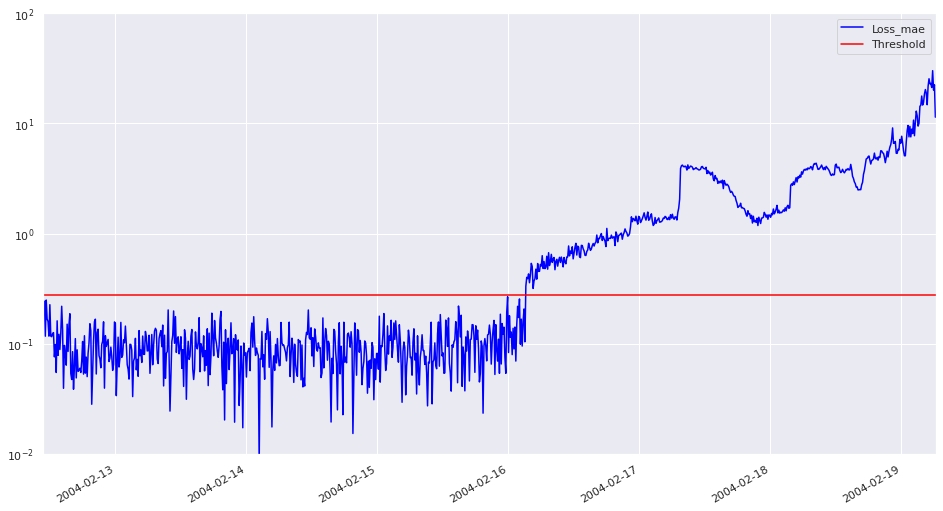

In [37]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [22]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved


In [1]:
! python -V

Python 3.6.13 :: Anaconda, Inc.
